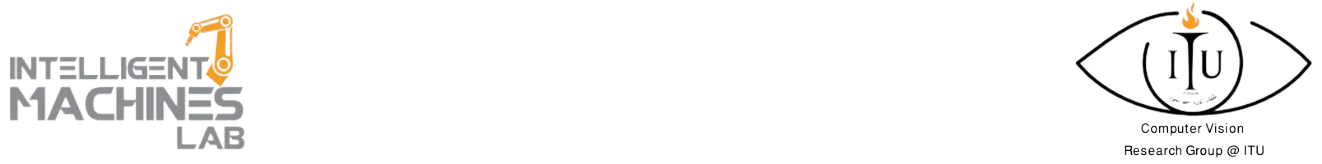

## Generative AI & LLM Fall 2024
## Assignment 2: Implementing a VAE using CNN and pytorch

In this assignment, you will implement a VAE using CNN and pytorch. You will use the MNIST dataset for this assignment.

**You will need to implement the following:**

1. The VAE Model
2. Kaiming Initialization also known as He Initialization (https://paperswithcode.com/method/he-initialization)
3. The VAE loss function
4. The forward pass
5. The training loop
6. The evaluation loop
7. The sampling loop
8. Visualize the latent space


**Guidelines:**

1. Use this notebook as a template to implement the VAE model.
2. Try your best to avoid using ChatGPT or any other LLM to complete this assignment.
3. If you get stuck, please reach out at `manzoor.rohan97@gmail.com`
4. Ensure proper formatting of the code.
5. While you will be implementing the assignment on Colab, you are also required to upload the project to github and share the link with us.


**The assignment will be evaluated based on the following criteria:**

| Criteria                | Marks |
|-------------------------|-------|
| 1. VAE model            | 2.5   |
| 2. Training Loop        | 2.5   |
| 3. Correct Sampling     | 2.0   |
| 4. Viva                 | 3.0   |
| Total                   | 10.0  |


Name: `Abdul rehman`

Reg No: `Phdcs23002`

Github Link: `https://github.com/Abryhm/GenAI`

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torchvision import datasets, transforms
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from torchvision.utils import make_grid


# Model Definition

In [14]:

def weights_init(m):
    torch.nn.init.kaiming_normal_(m.weight,mode='fan_in',nonlinearity='relu')
    if m.bias is not None:
        torch.nn.init.zeros_(m.bias)

class CNN_VAE(nn.Module):
    def __init__(self, input_channels=1, h_dims=[32, 64], latent_dims=20):
        """
        Initializes the CNN_VAE model.

        Args:
            input_channels (int): Number of input channels (e.g., 1 for grayscale images).
            h_dims (list): A list defining the number of output channels for each convolutional layer in the encoder.
            latent_dims (int): Dimensionality of the latent space.
        """
        super(CNN_VAE, self).__init__()
        # TODO: Initialize the encoder Layers
        # You encoder will have 2 convolutional layers, a fixed kernel size of 3, stride of 2, padding of 1
        # The output of the encoder will be flattened to a single vector
        self.conv1=nn.Conv2d(input_channels,32,kernel_size=3,stride=2,padding=1)
        self.conv2=nn.Conv2d(32,64,kernel_size=3,stride=2,padding=1)
        self.relu=nn.ReLU()
        # TODO: Initialize the FC layers to output the mean and log variance
        #i will use average pooling and flattening before FClayer
        self.FC1=nn.Linear(64,128)
        self.FC_mean=nn.Linear(128,latent_dims)
        self.FC_var=nn.Linear(128,latent_dims)
        self.FC2=nn.Linear(latent_dims,64 * 7 * 7)

        # TODO: Initialize the decoder layers
        # The decoder will have 2 transposed convolutional layers, a fixed kernel size of 3, stride of 2, padding of 1
        # The output of the decoder will be a tensor of the same size as the input
        self.convTR_1=nn.ConvTranspose2d(64,32,kernel_size=3, stride=2, padding=1,output_padding=1)
        self.convTR_2=nn.ConvTranspose2d(32,input_channels,kernel_size=3, stride=2, padding=1,output_padding=1)

    def reparametrize(self, mu, logvar):
        """
        Reparameterization trick to sample from the latent space.

        Args:
            mu (torch.Tensor): Mean of the latent distribution.
            logvar (torch.Tensor): Log variance of the latent distribution.

        Returns:
            torch.Tensor: Sampled latent variable from the distribution defined by mu and logvar.
        """
        # TODO: Implement the reparametrization trick. Notice the input argument is logvar and not sigma. Can you guess why?
        std=torch.exp(0.5*logvar)
        shape=std.shape
        epsilon=torch.randn(shape)
        sam_latent_var=mu+(std*epsilon)
        return sam_latent_var
    def weights_init(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
    def encode(self, x):
        """
        Encodes the input data into the latent space representation.

        Args:
            x (torch.Tensor): Input data (e.g., images) to be encoded.

        Returns:
            tuple: A tuple containing:
                - mu (torch.Tensor): Mean of the latent distribution.
                - logvar (torch.Tensor): Log variance of the latent distribution.
        """

        x=self.relu(self.conv1(x))
        x=self.relu(self.conv2(x))
        batch, _, _, _ = x.shape
        x=F.adaptive_avg_pool2d(x, 1).reshape(batch, -1)
        h=self.FC1(x)
        mu=self.FC_mean(h)
        logvar=self.FC_var(h)
        return mu, logvar

    def decode(self, z):
        """
        Decodes the latent representation back to the original data space.

        Args:
            z (torch.Tensor): Latent representation to be decoded.

        Returns:
            torch.Tensor: Reconstructed data from the latent representation.
        """
        z=self.FC2(z)
        z = z.view(-1, 64, 7, 7)
        x=self.relu(self.convTR_1(z))
        x=self.relu(self.convTR_2(x))
        Reconstructed_data=torch.sigmoid(x)
        return Reconstructed_data

    def forward(self, x):
        """
        Forward pass through the model.

        Args:
            x (torch.Tensor): Input data (e.g., images) for reconstruction.

        Returns:
            tuple: A tuple containing:
                - x_reconstructed (torch.Tensor): Reconstructed input data.
                - mu (torch.Tensor): Mean of the latent distribution.
                - logvar (torch.Tensor): Log variance of the latent distribution.
        """
        mu,logvar=self.encode(x)
        z=self.reparametrize(mu,logvar)
        # z=self.FC1(z)
        # z = z.view(-1, 64, 7, 7)
        x_reconstructed=self.decode(z)
        return x_reconstructed,mu,logvar

# Usage
INPUT_CHANNELS = 1
INPUT_SIZE = 28
model = CNN_VAE(input_channels=INPUT_CHANNELS)
output, mu, logvar = model.forward(torch.randn((1, INPUT_CHANNELS, INPUT_SIZE, INPUT_SIZE)))
print(output.shape)
# Should print: torch.Size([1, 1, 28, 28])


torch.Size([1, 1, 28, 28])


In [25]:
def weights_init(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

class CNN_VAE(nn.Module):
    def __init__(self, input_channels=1, h_dims=[32, 64], latent_dims=20):
        """
        Initializes the CNN_VAE model.

        Args:
            input_channels (int): Number of input channels (e.g., 1 for grayscale images).
            h_dims (list): A list defining the number of output channels for each convolutional layer in the encoder.
            latent_dims (int): Dimensionality of the latent space.
        """
        super(CNN_VAE, self).__init__()
        self.conv1=nn.Conv2d(input_channels,32,kernel_size=3,stride=2,padding=1)
        self.conv2=nn.Conv2d(32,64,kernel_size=3,stride=2,padding=1)
        self.relu=nn.LeakyReLU()
        #fully conneceted layers
        self.FC1=nn.Linear(64,128)
        self.FC_mean=nn.Linear(128,latent_dims)
        self.FC_var=nn.Linear(128,latent_dims)
        self.FC2=nn.Linear(latent_dims,64 * 7 * 7)
        #Decoder upscaling conv
        self.convTR_1=nn.ConvTranspose2d(64,32,kernel_size=3, stride=2, padding=1,output_padding=1)
        self.convTR_2=nn.ConvTranspose2d(32,input_channels,kernel_size=3, stride=2, padding=1,output_padding=1)

    def reparametrize(self, mu, logvar):
        """
        Reparameterization trick to sample from the latent space.

        Args:
            mu (torch.Tensor): Mean of the latent distribution.
            logvar (torch.Tensor): Log variance of the latent distribution.

        Returns:
            torch.Tensor: Sampled latent variable from the distribution defined by mu and logvar.
        """
        # TODO: Implement the reparametrization trick. Notice the input argument is logvar and not sigma. Can you guess why?
        std=torch.exp(0.5*logvar)
        shape_std=std.shape
        epsilon=torch.randn(shape_std)
        sam_latent_var=mu+(std*epsilon)
        return sam_latent_var

    def encode(self, x):

        x=self.relu(self.conv1(x))
        x=self.relu(self.conv2(x))
        batch, _, _, _ = x.shape
        x=F.adaptive_avg_pool2d(x, 1).reshape(batch, -1)
        h=self.FC1(x)
        mu=self.FC_mean(h)
        logvar=self.FC_var(h)
        return mu, logvar

    def decode(self, z):
        """
        Decodes the latent representation back to the original data space.

        Args:
            z (torch.Tensor): Latent representation to be decoded.

        Returns:
            torch.Tensor: Reconstructed data from the latent representation.
        """
        z=self.FC2(z)
        z = z.view(-1, 64, 7, 7)
        x=self.relu(self.convTR_1(z))
        x=self.relu(self.convTR_2(x))
        Reconstructed_data=torch.sigmoid(x)
        return Reconstructed_data

    def forward(self, x):
        """
        Forward pass through the model.

        Args:
            x (torch.Tensor): Input data (e.g., images) for reconstruction.

        Returns:
            tuple: A tuple containing:
                - x_reconstructed (torch.Tensor): Reconstructed input data.
                - mu (torch.Tensor): Mean of the latent distribution.
                - logvar (torch.Tensor): Log variance of the latent distribution.
        """
        mu,logvar=self.encode(x)
        z=self.reparametrize(mu,logvar)
        # z=self.FC1(z)
        # z = z.view(-1, 64, 7, 7)
        x_reconstructed=self.decode(z)
        return x_reconstructed,mu,logvar

INPUT_CHANNELS = 1
INPUT_SIZE = 28
model = CNN_VAE(input_channels=INPUT_CHANNELS)
output, mu, logvar = model.forward(torch.randn((64, INPUT_CHANNELS, INPUT_SIZE, INPUT_SIZE)))
#summary(model, (1, 28, 28))
print(output.shape)

torch.Size([64, 1, 28, 28])


# Dataset Loading

In [9]:
# Hyper-parameters
# you can change these to see how the model performs

DEVICE = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
INPUT_DIMS = 1
HID_DIMS = [32, 64]
Z_DIMS = 20
NUM_EPOCHS = 50
LR = 3e-4
BATCH_SIZE = 64
VAL_AFTER = 800

In [8]:
# Loading dataset

# TODO: Load the MNIST dataset and prepare the dataloaders.
# You can use the torchvision.datasets.MNIST and torch.utils.data.DataLoader to load the dataset.
# You will need separate daataloader for train and test set
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors)  # Normalize images
])

# Load the MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Prepare DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 41459128.18it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1186162.84it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 10345340.85it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 7709643.37it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [26]:


def plot_image(img, nrow=10):
    plt.figure(figsize=(10, 6))
    plt.imshow(make_grid(img, nrow=nrow).permute(1, 2, 0).cpu().numpy())
    plt.axis('off')
    plt.show()

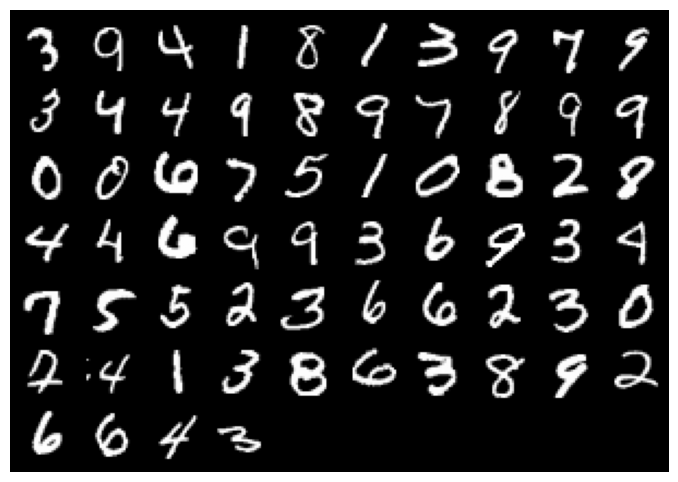

In [11]:
images, labels = next(iter(train_loader))  # Get a batch of images and labels
plot_image(images, nrow=10)

# Training Loop

In [5]:
# Define VAE loss
def vae_loss(reconstructed_x, x, mu, logvar):
    """
    Compute the VAE loss.

    Args:
        reconstructed_x (torch.Tensor): The reconstructed output from the decoder.
        x (torch.Tensor): The original input data.
        mu (torch.Tensor): The mean of the latent distribution.
        logvar (torch.Tensor): The log variance of the latent distribution.

    Returns:
        torch.Tensor: The total VAE loss.
    """
    # Reconstruction loss (Binary Cross-Entropy loss)
    BCE=F.binary_cross_entropy(reconstructed_x, x, reduction='sum')
    KL = torch.mean(-0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(),dim=1),dim=0)
    vae_loss=BCE+KL
    return vae_loss


In [19]:


# Hyperparameters
NUM_EPOCHS = 10
BATCH_SIZE = 64
INPUT_CHANNELS = 1
INPUT_SIZE = 28
HID_DIMS = [32, 64]  # Hidden dimensions for the encoder
Z_DIMS = 20           # Latent space dimensions
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Initialize the model and optimizer
model = CNN_VAE(input_channels=INPUT_CHANNELS, h_dims=HID_DIMS, latent_dims=Z_DIMS).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9)
# Lists to store losses
train_losses = []
eval_losses = []

# Prepare data loaders (assuming train_loader and test_loader are defined)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Training and Evaluation Loop
for epoch in range(NUM_EPOCHS):
    model.train()
    epoch_train_loss = 0

    # Training loop with progress bar
    for images, _ in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{NUM_EPOCHS}"):
        images = images.to(DEVICE)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        reconstructed_images, mu, logvar = model(images)

        # Compute loss
        loss = vae_loss(reconstructed_images, images, mu, logvar)

        # Backward pass
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()

    # Average training loss
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    # scheduler.step()
    # Evaluation loop
    model.eval()
    epoch_eval_loss = 0

    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(DEVICE)
            reconstructed_images, mu, logvar = model(images)
            loss = vae_loss(reconstructed_images, images, mu, logvar)
            epoch_eval_loss += loss.item()

    # Average evaluation loss
    avg_eval_loss = epoch_eval_loss / len(test_loader)
    eval_losses.append(avg_eval_loss)

    print(f"Epoch {epoch + 1}/{NUM_EPOCHS} | Train Loss: {avg_train_loss:.4f} | Eval Loss: {avg_eval_loss:.4f}")



Epoch 1/10: 100%|██████████| 938/938 [00:58<00:00, 16.00it/s]


Epoch 1/10 | Train Loss: 12080.1279 | Eval Loss: 10901.8873


Epoch 2/10: 100%|██████████| 938/938 [00:59<00:00, 15.74it/s]


Epoch 2/10 | Train Loss: 9874.3400 | Eval Loss: 9368.5539


Epoch 3/10: 100%|██████████| 938/938 [01:01<00:00, 15.35it/s]


Epoch 3/10 | Train Loss: 9064.1951 | Eval Loss: 8718.7860


Epoch 4/10: 100%|██████████| 938/938 [00:59<00:00, 15.76it/s]


Epoch 4/10 | Train Loss: 8576.9025 | Eval Loss: 8336.8799


Epoch 5/10: 100%|██████████| 938/938 [00:58<00:00, 15.99it/s]


Epoch 5/10 | Train Loss: 8320.1017 | Eval Loss: 8182.8782


Epoch 6/10: 100%|██████████| 938/938 [00:59<00:00, 15.75it/s]


Epoch 6/10 | Train Loss: 8109.5013 | Eval Loss: 7912.0526


Epoch 7/10: 100%|██████████| 938/938 [00:59<00:00, 15.75it/s]


Epoch 7/10 | Train Loss: 7959.2627 | Eval Loss: 7837.9449


Epoch 8/10: 100%|██████████| 938/938 [00:59<00:00, 15.70it/s]


Epoch 8/10 | Train Loss: 7865.9677 | Eval Loss: 7882.2362


Epoch 9/10: 100%|██████████| 938/938 [01:00<00:00, 15.57it/s]


Epoch 9/10 | Train Loss: 7777.9055 | Eval Loss: 7606.5731


Epoch 10/10: 100%|██████████| 938/938 [00:58<00:00, 15.99it/s]


Epoch 10/10 | Train Loss: 7724.2024 | Eval Loss: 7612.6931


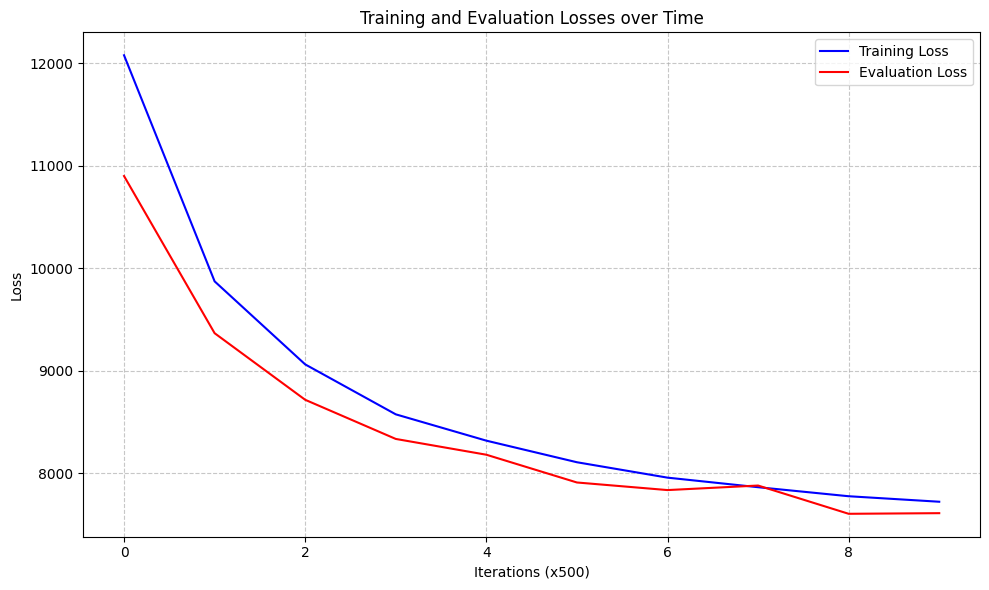

In [20]:
# Visualize your losses as your training progresses

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(eval_losses, label='Evaluation Loss', color='red')
plt.title('Training and Evaluation Losses over Time')
plt.xlabel('Iterations (x500)')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# Visualizations

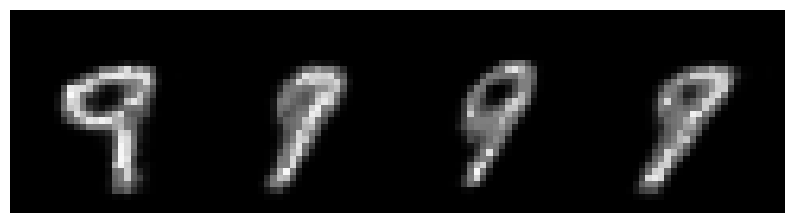

In [22]:
def visualize_generations(model, digit, num_examples):
    # Set the model to evaluation mode
    model.eval()

    # Load the digit images from the dataset (for example, MNIST)
    # Assuming you have a dataset variable `dataset` with digit images
    digit_i = [img for img, label in train_dataset if label == digit][:num_examples]
    digit_i = torch.stack(digit_i).to(DEVICE)

    # Encode the latent space
    with torch.no_grad():
        mu, log_var = model.encode(digit_i)
    z_samples = model.reparametrize(mu, log_var)
    recon_images = model.decode(z_samples)
    plot_image(recon_images)



digit = 9
num_examples = 4
visualize_generations(model, digit, num_examples)

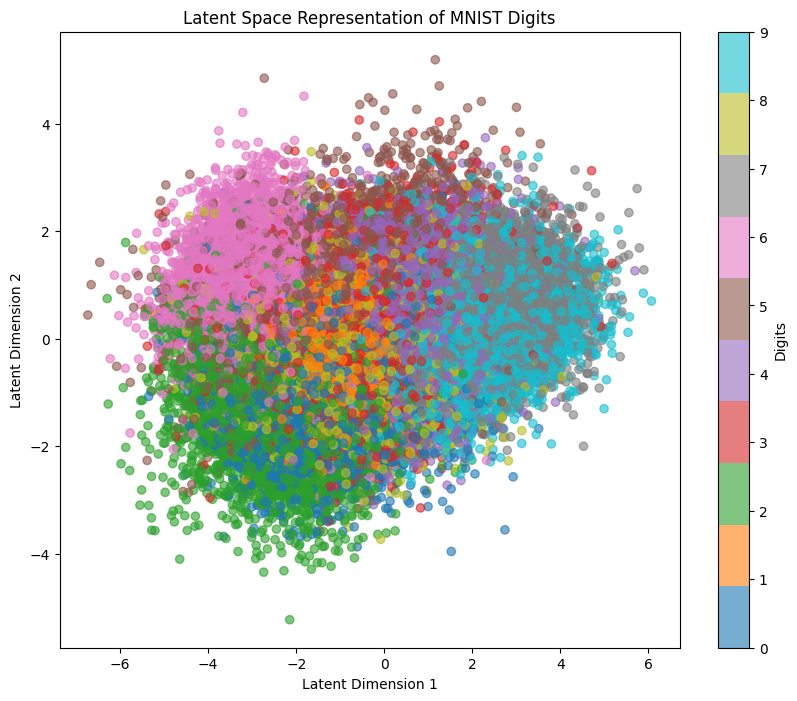

In [24]:


def visualize_latens(dataloader, model):
    # Set the model to evaluation mode
    model.eval()

    all_latent_vars = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(DEVICE)
            mu, logvar = model.encode(images)
            z_samples = model.reparametrize(mu, logvar)

            all_latent_vars.append(z_samples.cpu())
            all_labels.append(labels.cpu())

    # Concatenate all the latent variables and labels
    all_latent_vars = torch.cat(all_latent_vars).numpy()
    all_labels = torch.cat(all_labels).numpy()

    # Create a scatter plot of the latent space
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(all_latent_vars[:, 0], all_latent_vars[:, 1], c=all_labels, cmap='tab10', alpha=0.6)
    plt.colorbar(scatter, label='Digits')
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.title('Latent Space Representation of MNIST Digits')
    plt.show()

# Example usage
# Assuming you have a DataLoader for the MNIST test dataset
test_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
visualize_latens(test_loader, model)


